<a href="https://colab.research.google.com/github/Stephl99/coremotion_marketing_analysis/blob/master/Coremotion_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [500]:
R.version.string

[1] "R version 4.5.1 (2025-06-13)"

In [574]:
# install.packages("corrplot")
# devtools::install_github ("braverock/PerformanceAnalytics")
# install.packages("car")
# install.packages("glmnet")
install.packages(c("lmtest","sandwich"), repos = "https://cloud.r-project.org")

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [573]:
# libraries ------------------
library(dplyr)
library(tidyr)
library(ggplot2)
library(corrplot)
library(PerformanceAnalytics)
library(lubridate)
library(car)
library(MASS)
library(glmnet)
library(lmtest)

In [503]:
outliers_iqr <- function(x) {
  x <- suppressWarnings(as.numeric(x))
  q1 <- stats::quantile(x, 0.25, na.rm = TRUE)
  q3 <- stats::quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower <- q1 - 1.5 * iqr
  upper <- q3 + 1.5 * iqr
  which(is.finite(x) & (x < lower | x > upper))
}


imput_iqr <- function(x) {
  x <- suppressWarnings(as.numeric(x))
  q1 <- stats::quantile(x, 0.25, na.rm = TRUE)
  q3 <- stats::quantile(x, 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower <- q1 - 1.5 * iqr
  upper <- q3 + 1.5 * iqr
  mask <- is.finite(x) & (x < lower | x > upper)
  x_imp <- x
  if (any(mask)) x_imp[mask] <- stats::runif(sum(mask), min = q1, max = q3)
  x_imp
}


safe_div <- function(x, y, eps = .Machine$double.eps) {
  x <- suppressWarnings(as.numeric(x))
  y <- suppressWarnings(as.numeric(y))
  bad <- !is.finite(y) | abs(y) <= eps
  res <- x / y
  res[bad] <- NA_real_
  res
}


scale_with <- function(df, cols, mu, sdv) {
  for (nm in cols) {
    if (!nm %in% names(df)) next
    v <- suppressWarnings(as.numeric(df[[nm]]))
    s <- sdv[[nm]]
    m <- mu[[nm]]
    if (is.na(s) || s == 0) {
      df[[nm]] <- v - m
    } else {
      df[[nm]] <- (v - m) / s
    }
  }
  df
}


metrics <- function(y, yhat){
  y    <- suppressWarnings(as.numeric(y))
  yhat <- suppressWarnings(as.numeric(yhat))
  rmse <- sqrt(mean((y - yhat)^2, na.rm = TRUE))
  mape <- mean(abs(y - yhat) / pmax(abs(y), .Machine$double.eps), na.rm = TRUE)
  r2   <- 1 - sum((y - yhat)^2, na.rm = TRUE) / sum((y - mean(y, na.rm = TRUE))^2, na.rm = TRUE)
  c(RMSE = rmse, MAPE = mape, R2 = r2)
}

In [504]:
# read csv -------------------
dat <- read.csv("main_week_table.csv", header = TRUE, sep = ",")
dat$week_start <- as.Date(dat$week_start)
dat$region     <- factor(dat$region)

In [505]:
dat %>% glimpse()

Rows: 676
Columns: 21
$ week_start         <date> 2020-01-05, 2020-01-12, 2020-01-19, 2020-01-26, 20…
$ region             <fct> East, East, East, East, East, East, East, East, Eas…
$ Dollar_Sales       <dbl> 2921014, 2738600, 3097300, 2841381, 3130066, 278903…
$ Units_Sales        <int> 4460, 3927, 4358, 4093, 4445, 4344, 6013, 4450, 482…
$ gdp_growth         <dbl> 3.11, 3.11, 3.11, 3.11, 3.50, 3.50, 3.50, 3.50, 3.2…
$ inflation          <dbl> 2.77, 2.77, 2.77, 2.77, 2.40, 2.40, 2.40, 2.40, 2.6…
$ unemployment       <dbl> 7.77, 7.77, 7.77, 7.77, 8.49, 8.49, 8.49, 8.49, 7.5…
$ banner_impressions <int> 25517796, 28992557, 34970672, 35717186, 35024216, 3…
$ banner_cost        <dbl> 157376.1, 171153.2, 189219.4, 185689.2, 199334.0, 1…
$ olv_impressions    <int> 8359056, 7940685, 10385878, 10071275, 10168539, 918…
$ spend_olv          <dbl> 146025.2, 248397.5, 289548.0, 210728.4, 189607.6, 1…
$ social_impressions <int> 21692159, 25701839, 26699302, 26747757, 28621363, 2…
$ social_investmen

In [506]:
# data structure ----------------
print(head(dat))  # first rows
# tail(dat)
print(dim(dat)) # dim
print(colnames(dat))  # colnames

print(summary(dat))

  week_start region Dollar_Sales Units_Sales gdp_growth inflation unemployment
1 2020-01-05   East      2921014        4460       3.11      2.77         7.77
2 2020-01-12   East      2738600        3927       3.11      2.77         7.77
3 2020-01-19   East      3097300        4358       3.11      2.77         7.77
4 2020-01-26   East      2841381        4093       3.11      2.77         7.77
5 2020-02-02   East      3130066        4445       3.50      2.40         8.49
6 2020-02-09   East      2789033        4344       3.50      2.40         8.49
  banner_impressions banner_cost olv_impressions spend_olv social_impressions
1           25517796    157376.1         8359056  146025.2           21692159
2           28992557    171153.2         7940685  248397.5           25701839
3           34970672    189219.4        10385878  289548.0           26699302
4           35717186    185689.2        10071275  210728.4           26747757
5           35024216    199334.0        10168539  189607.

In [507]:
# sales per region
aggregate(Dollar_Sales ~ region, data = dat, sum, na.rm = TRUE)

region,Dollar_Sales
<fct>,<dbl>
East,480757756
North,383301972
South,512714656
West,247675211


In [508]:
# mean weekly sales per region
aggregate(Dollar_Sales ~ region, data = dat, mean, na.rm = TRUE)

region,Dollar_Sales
<fct>,<dbl>
East,2844720
North,2268059
South,2817113
West,1587662


In [509]:
# mean weekly units_sales per region
aggregate(Units_Sales  ~ region, data = dat, mean, na.rm = TRUE)

region,Units_Sales
<fct>,<dbl>
East,4301.704
North,3589.237
South,4175.242
West,2587.096


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


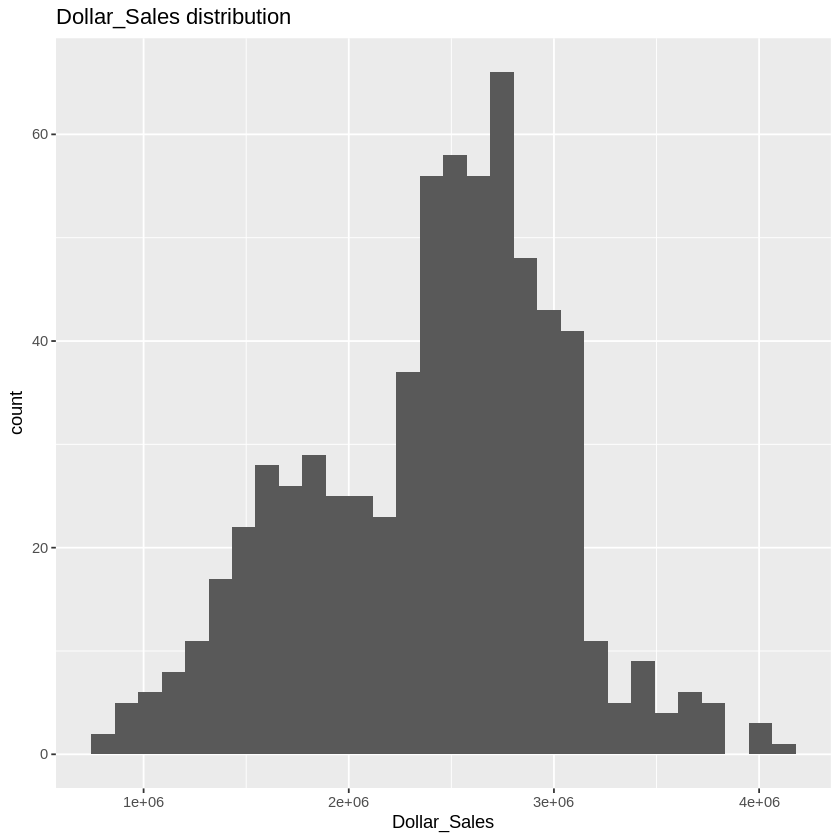

In [510]:
# Distribución de ventas
ggplot(dat, aes(x = Dollar_Sales)) +
  geom_histogram() +
  labs(title = "Dollar_Sales distribution")

Warning message:
“Removed 354 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


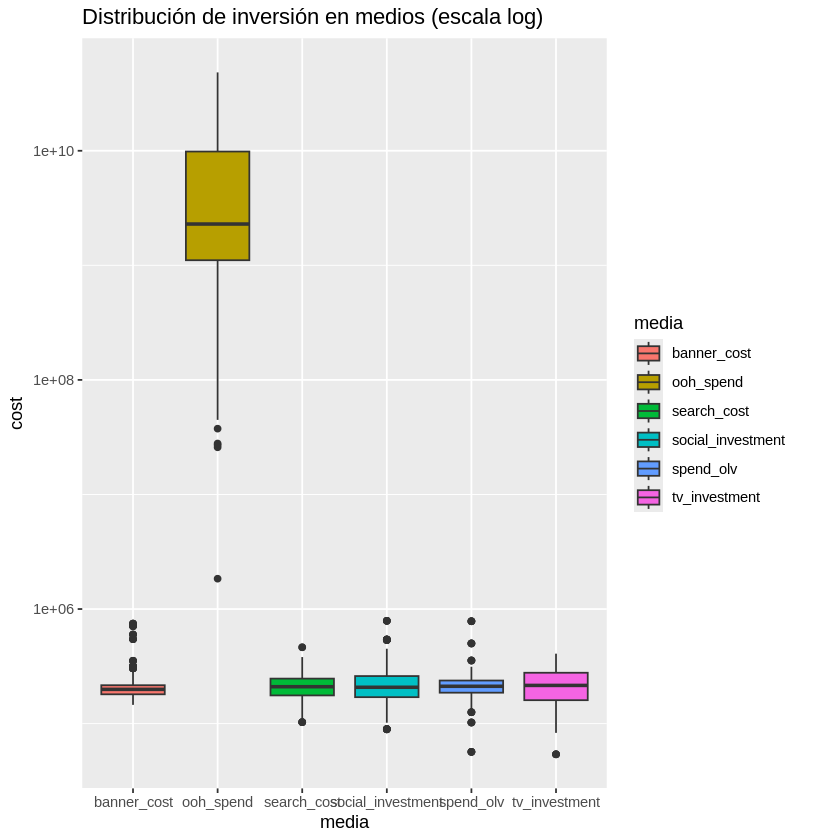

In [511]:
# Gasto en medios principales
media_cost <- c("banner_cost","spend_olv","social_investment",
                "search_cost","ooh_spend","tv_investment")

ggplot(
  dat %>% tidyr::pivot_longer(
    cols = all_of(media_cost),
    names_to = "media",
    values_to = "cost"
  ),
  aes(x = media, y = cost, fill = media)
) +
  geom_boxplot() +
  scale_y_log10() +
  labs(title = "Distribución de inversión en medios (escala log)")

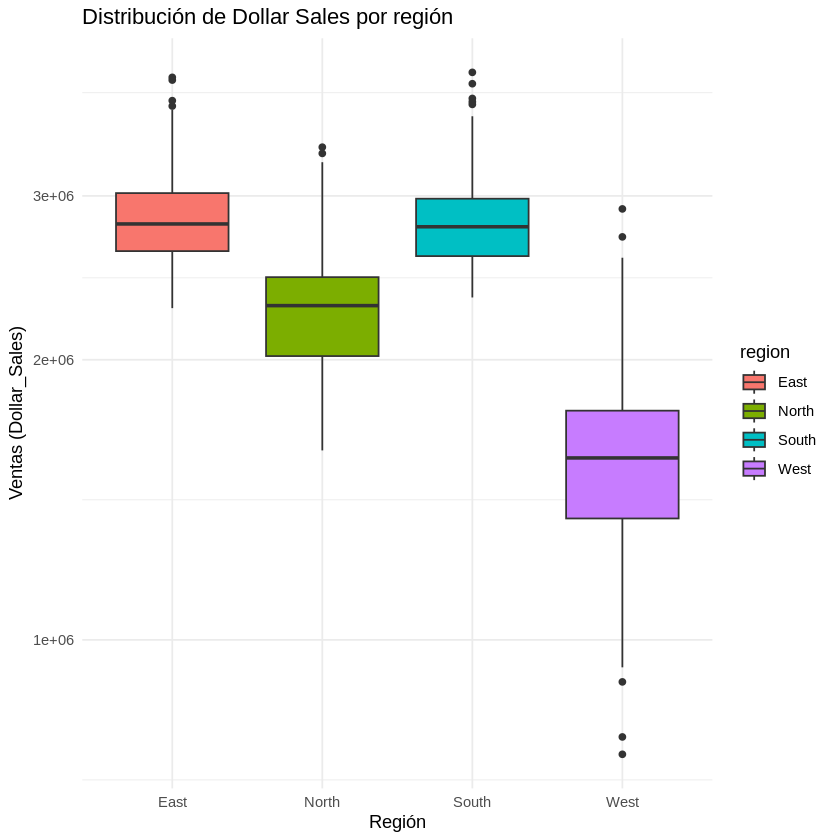

In [512]:
ggplot(dat, aes(x = region, y = Dollar_Sales, fill = region)) +
  geom_boxplot() +
  scale_y_log10() +  # útil si hay outliers grandes
  labs(title = "Distribución de Dollar Sales por región",
       x = "Región",
       y = "Ventas (Dollar_Sales)") +
  theme_minimal()


In [513]:
dat %>%
  group_by(region) %>%
  summarise(n(),
    mean  = mean(Dollar_Sales, na.rm = TRUE),
    sd    = sd(Dollar_Sales, na.rm = TRUE),
    median= median(Dollar_Sales, na.rm = TRUE),
    min   = min(Dollar_Sales, na.rm = TRUE),
    max   = max(Dollar_Sales, na.rm = TRUE)
  )

region,n(),mean,sd,median,min,max
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
East,169,2844720,334592.0,2798926,2272461.2,4022988
North,169,2268059,341937.8,2286730,1598248.3,3384603
South,182,2817113,333028.9,2779480,2333507.7,4072890
West,156,1587662,366484.8,1568609,753339.8,2905029


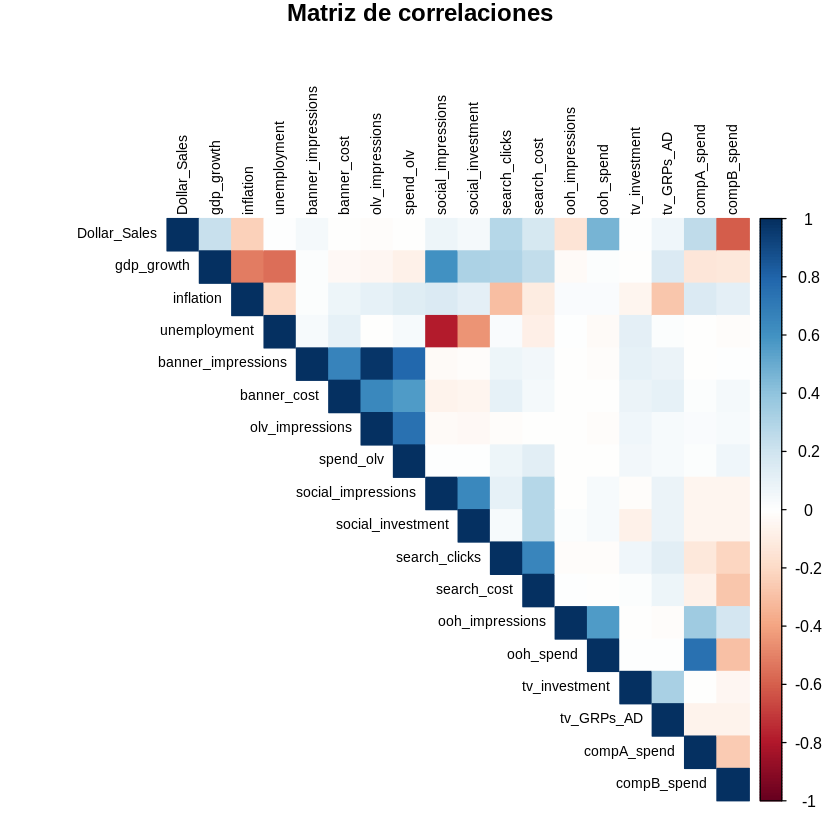

In [514]:
# corr matrix
num_vars <- dat %>%
  dplyr::select(where(is.numeric)) %>%
  dplyr::select(-any_of("Units_Sales"))

cor_mat <- cor(num_vars, use = "pairwise.complete.obs")

corrplot(cor_mat, method = "color", type = "upper",
         tl.cex = 0.7, tl.col = "black",
         title = "Matriz de correlaciones", mar=c(0,0,1,0))

In [515]:
cor_mat

,Dollar_Sales,gdp_growth,inflation,unemployment,banner_impressions,banner_cost,olv_impressions,spend_olv,social_impressions,social_investment,search_clicks,search_cost,ooh_impressions,ooh_spend,tv_investment,tv_GRPs_AD,compA_spend,compB_spend
Dollar_Sales,1.000000000,0.225686186,-0.23301411,0.0098922242,0.040394793,-0.007534049,-0.0119178087,-0.004552325,0.074635935,0.049009005,0.28145965,0.172476604,-0.1452766835,0.465735848,0.004776962,0.065260736,0.252570026,-0.60273664
gdp_growth,0.225686186,1.000000000,-0.51356315,-0.5557894389,0.015182390,-0.039342897,-0.0477362971,-0.079170540,0.602074593,0.318470704,0.30900994,0.241505335,-0.0241310823,0.011489296,-0.009470209,0.153709345,-0.135644894,-0.12334072
inflation,-0.233014110,-0.513563147,1.00000000,-0.1917337958,0.016751029,0.077859313,0.1004337710,0.134770163,0.151149086,0.115486078,-0.30010224,-0.109229408,0.0226944561,0.023443766,-0.058054697,-0.278090577,0.152526746,0.11437256
unemployment,0.009892224,-0.555789439,-0.19173380,1.0000000000,0.030129812,0.100632361,-0.0001692566,0.039449894,-0.783963676,-0.446374209,0.02086393,-0.087034739,0.0008879576,-0.026677729,0.111230661,0.017105838,-0.009310924,-0.01586429
banner_impressions,0.040394793,0.015182390,0.01675103,0.0301298118,1.000000000,0.668315883,0.9782990503,0.784849060,-0.022565229,-0.017696644,0.07752697,0.050022050,-0.0081005702,-0.011169436,0.104940060,0.083491400,-0.006585589,0.00778719
banner_cost,-0.007534049,-0.039342897,0.07785931,0.1006323607,0.668315883,1.000000000,0.6472361035,0.564033273,-0.061447423,-0.050790599,0.10895999,0.041709286,-0.0082826843,-0.006212420,0.083166168,0.108171882,0.011848158,0.04600759
olv_impressions,-0.011917809,-0.047736297,0.10043377,-0.0001692566,0.978299050,0.647236103,1.0000000000,0.744790580,-0.029743006,-0.037996179,-0.01276498,-0.005965628,-0.0081955078,-0.011746686,0.066547047,0.030282725,0.021431047,0.03419564
spend_olv,-0.004552325,-0.079170540,0.13477016,0.0394498943,0.784849060,0.564033273,0.7447905803,1.000000000,0.005231816,0.007495681,0.07850385,0.121592905,-0.0037111815,-0.009821170,0.055327774,0.030359577,0.014586712,0.06121569
social_impressions,0.074635935,0.602074593,0.15114909,-0.7839636756,-0.022565229,-0.061447423,-0.0297430065,0.005231816,1.000000000,0.645995126,0.10513629,0.287465840,-0.0056822551,0.032359920,-0.010487910,0.084420987,-0.050194394,-0.05735203
social_investment,0.049009005,0.318470704,0.11548608,-0.4463742094,-0.017696644,-0.050790599,-0.0379961788,0.007495681,0.645995126,1.000000000,0.03270400,0.283373246,0.0113524384,0.035470278,-0.072671291,0.080207746,-0.059870339,-0.05359326


In [516]:
colnames(dat)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"

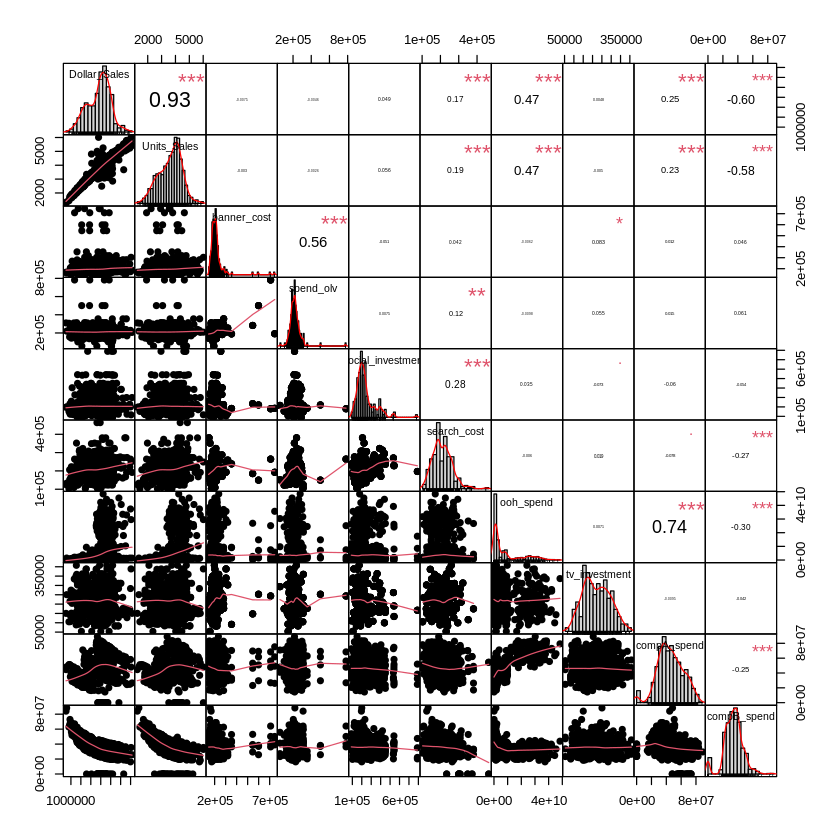

In [517]:
cost_vars <- c('Dollar_Sales','Units_Sales','banner_cost','spend_olv','social_investment','search_cost',
               'ooh_spend','tv_investment', 'compA_spend','compB_spend')
cost_dat <- dat[, cost_vars]
chart.Correlation(cost_dat, histogram = TRUE, pch=19)

In [518]:
colnames(dat)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"

[1] "Dollar_Sales"       "banner_impressions" "olv_impressions"   
[4] "social_impressions" "search_clicks"      "ooh_impressions"   
[7] "tv_GRPs_AD"

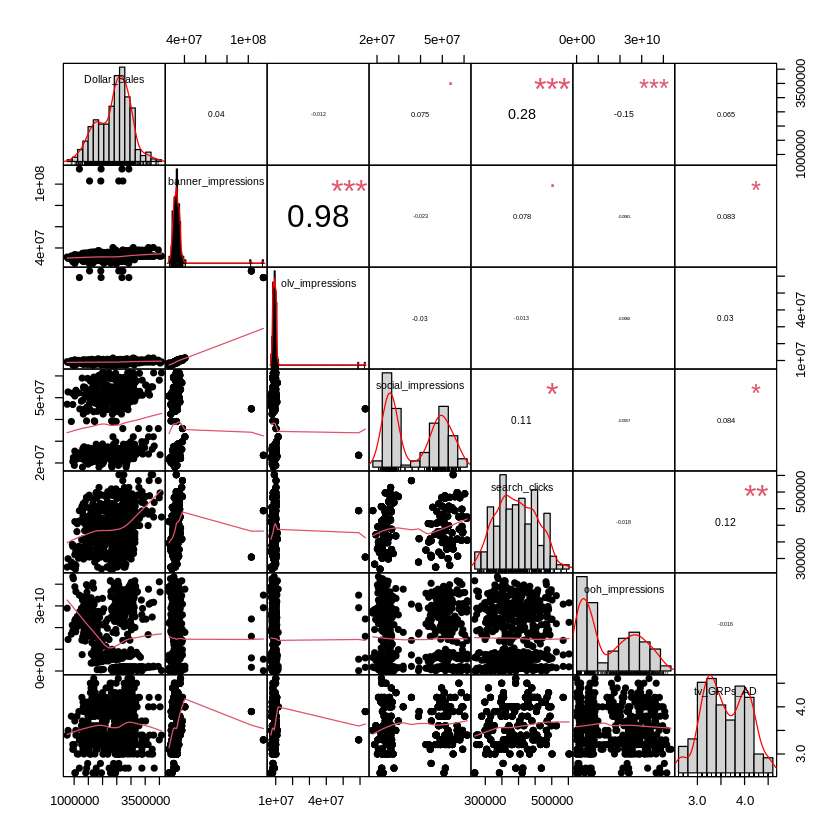

In [519]:
interaction_vars <- c('Dollar_Sales','banner_impressions','olv_impressions','social_impressions', 'search_clicks',
                      'ooh_impressions','tv_GRPs_AD')
interaction_dat <- dat[, interaction_vars]
interaction_vars
# str(interaction_dat)
chart.Correlation(interaction_dat, histogram = TRUE, pch=19)

In [520]:
# missing values
print(colSums(is.na(dat)))

# no records -> no media activity that week

media_vars <- c("banner_impressions", "banner_cost",
                "olv_impressions", "spend_olv",
                "social_impressions", "social_investment",
                "search_clicks", "search_cost",
                "ooh_impressions", "ooh_spend",
                "tv_investment", "tv_GRPs_AD",
                "compA_spend", "compB_spend")
macro_vars <- c("gdp_growth","inflation","unemployment")
ctrl_vars  <- c("compA_spend","compB_spend")
y_var <- "Dollar_Sales"

dat[media_vars] <- lapply(dat[media_vars],
                           function(x) replace(x, is.na(x), 0))

sapply(dat[media_vars], function(x) sum(is.na(x)))

na_weeks <- unique(dat$week_start[is.na(dat$gdp_growth)])
na_weeks

dat1 <- dat[!format(dat$week_start, "%Y") %in% c("2019","2023"), ]

        week_start             region       Dollar_Sales        Units_Sales 
                 0                  0                  0                  0 
        gdp_growth          inflation       unemployment banner_impressions 
                52                 52                 52                 52 
       banner_cost    olv_impressions          spend_olv social_impressions 
                52                 52                 52                 52 
 social_investment      search_clicks        search_cost    ooh_impressions 
                52                 66                 66                 52 
         ooh_spend      tv_investment         tv_GRPs_AD        compA_spend 
                52                 80                 80                 10 
       compB_spend 
                 5 


banner_impressions        banner_cost    olv_impressions          spend_olv 
                 0                  0                  0                  0 
social_impressions  social_investment      search_clicks        search_cost 
                 0                  0                  0                  0 
   ooh_impressions          ooh_spend      tv_investment         tv_GRPs_AD 
                 0                  0                  0                  0 
       compA_spend        compB_spend 
                 0                  0

[1] "2023-01-01" "2023-01-08" "2023-01-15" "2023-01-22" "2023-01-29"
 [6] "2023-02-05" "2023-02-12" "2023-02-19" "2023-02-26" "2023-03-05"
[11] "2023-03-12" "2023-03-19" "2023-03-26" "2019-10-06" "2019-10-13"
[16] "2019-10-20" "2019-10-27" "2019-11-03" "2019-11-10" "2019-11-17"
[21] "2019-11-24" "2019-12-01" "2019-12-08" "2019-12-15" "2019-12-22"
[26] "2019-12-29"

In [521]:
# outliers
numeric_vars <- dat1[, sapply(dat1, is.numeric)]

outlier_indices <- lapply(numeric_vars, outliers_iqr)

outlier_summary <- data.frame(
  variable = names(outlier_indices),
  n_outliers = sapply(outlier_indices, length),
  perc_outliers = round(100 * sapply(outlier_indices, length) / nrow(dat), 2)
)

print(outlier_summary)

                             variable n_outliers perc_outliers
Dollar_Sales             Dollar_Sales          0          0.00
Units_Sales               Units_Sales          0          0.00
gdp_growth                 gdp_growth         20          2.96
inflation                   inflation          0          0.00
unemployment             unemployment          0          0.00
banner_impressions banner_impressions         12          1.78
banner_cost               banner_cost         48          7.10
olv_impressions       olv_impressions          8          1.18
spend_olv                   spend_olv         20          2.96
social_impressions social_impressions          0          0.00
social_investment   social_investment         48          7.10
search_clicks           search_clicks         28          4.14
search_cost               search_cost         36          5.33
ooh_impressions       ooh_impressions          0          0.00
ooh_spend                   ooh_spend        108       

In [522]:
vars_outliers <- c("gdp_growth", "banner_impressions", "banner_cost",
                   "olv_impressions", "spend_olv", "social_investment",
                   "search_clicks", "search_cost", "ooh_spend", "tv_GRPs_AD",
                   "compB_spend")

dat1_imput <- dat1 %>%
  mutate(across(all_of(vars_outliers), imput_iqr))

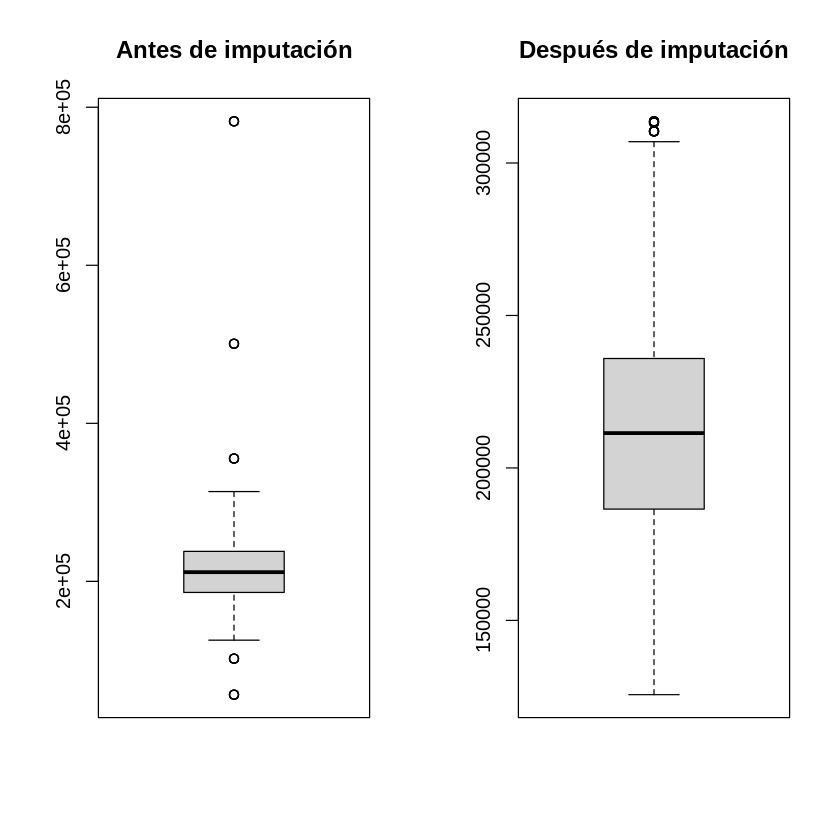

In [523]:
par(mfrow=c(1,2))
boxplot(dat1$spend_olv, main = "Antes de imputación")
boxplot(dat1_imput$spend, main = "Después de imputación")


In [524]:
colnames(dat1_imput)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"

In [525]:
cost_vars <- c('Dollar_Sales','Units_Sales','banner_cost','spend_olv','social_investment','search_cost',
               'ooh_spend','tv_investment', 'compA_spend','compB_spend')

In [526]:
dat_features <- dat1_imput %>%
  dplyr::mutate(
    week_start = as.Date(week_start),
    region     = as.factor(region)
  ) %>%
  dplyr::arrange(week_start, region) %>%
  dplyr::mutate(
    trend   = dplyr::row_number(),
    quarter = base::factor(lubridate::quarter(week_start)),
    total_spend = base::rowSums(
      cbind(banner_cost, spend_olv, social_investment, search_cost, ooh_spend, tv_investment),
      na.rm = TRUE
    ),
    CPM_banner = safe_div(banner_cost * 1000, banner_impressions),
    CPM_olv    = safe_div(spend_olv    * 1000, olv_impressions),
    CPC_search = safe_div(search_cost,          search_clicks),
    share_banner = safe_div(banner_cost,       total_spend),
    share_olv    = safe_div(spend_olv,         total_spend),
    share_social = safe_div(social_investment, total_spend),
    share_search = safe_div(search_cost,       total_spend),
    share_ooh    = safe_div(ooh_spend,         total_spend),
    share_tv     = safe_div(tv_investment,     total_spend)
  ) %>%
  dplyr::group_by(region) %>%
  dplyr::mutate(
    banner_cost_lag1 = dplyr::lag(banner_cost, 1),
    spend_olv_lag1   = dplyr::lag(spend_olv, 1),
    social_inv_lag1  = dplyr::lag(social_investment, 1),
    search_cost_lag1 = dplyr::lag(search_cost, 1),
    tv_invest_lag1   = dplyr::lag(tv_investment, 1)
  ) %>%
  dplyr::ungroup() %>%
  dplyr::mutate(
    ROI_proxy = safe_div(Dollar_Sales, total_spend)
  )  %>%
  tidyr::drop_na()

In [527]:
# features <- c('region','Dollar_Sales','Units_Sales','gdp_growth','inflation','banner_impressions','banner_cost',
#               'olv_impressions')

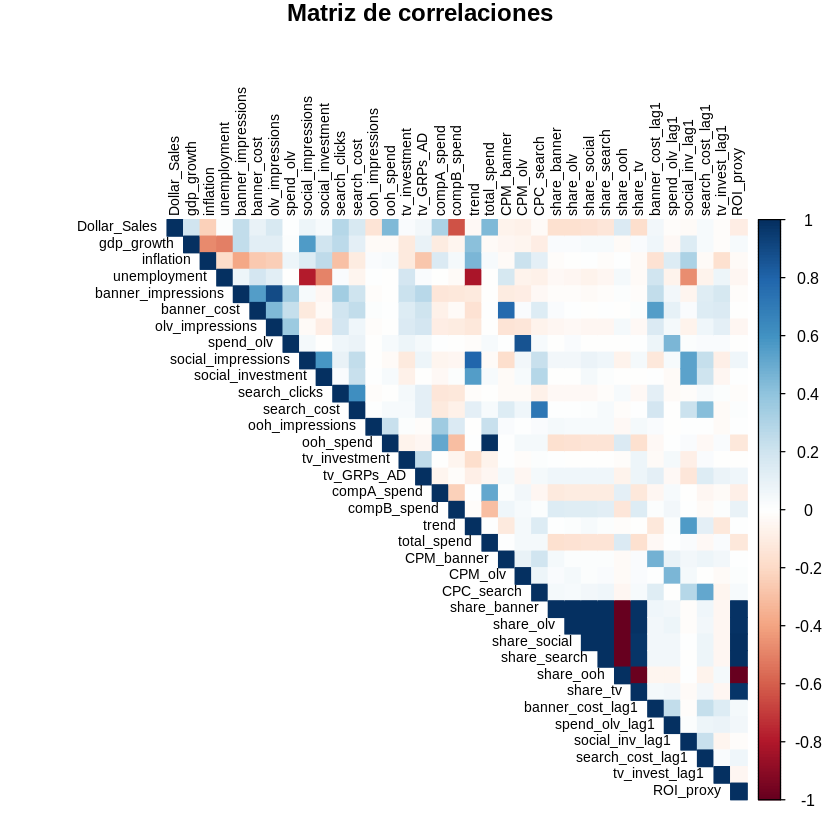

In [528]:
# corr matrix
num_vars <- dat_features %>%
  dplyr::select(where(is.numeric), -Units_Sales)

cor_mat <- cor(num_vars, use = "pairwise.complete.obs")

corrplot(cor_mat, method = "color", type = "upper",
         tl.cex = 0.7, tl.col = "black",
         title = "Matriz de correlaciones", mar=c(0,0,1,0))

In [529]:
colnames(dat_features)

[1] "week_start"         "region"             "Dollar_Sales"      
 [4] "Units_Sales"        "gdp_growth"         "inflation"         
 [7] "unemployment"       "banner_impressions" "banner_cost"       
[10] "olv_impressions"    "spend_olv"          "social_impressions"
[13] "social_investment"  "search_clicks"      "search_cost"       
[16] "ooh_impressions"    "ooh_spend"          "tv_investment"     
[19] "tv_GRPs_AD"         "compA_spend"        "compB_spend"       
[22] "trend"              "quarter"            "total_spend"       
[25] "CPM_banner"         "CPM_olv"            "CPC_search"        
[28] "share_banner"       "share_olv"          "share_social"      
[31] "share_search"       "share_ooh"          "share_tv"          
[34] "banner_cost_lag1"   "spend_olv_lag1"     "social_inv_lag1"   
[37] "search_cost_lag1"   "tv_invest_lag1"     "ROI_proxy"

In [530]:
# train - test split

# copy data
dat_model <- dat_features

dates <- sort(unique(dat_model$week_start))
cut_date <- dates[floor(0.8 * length(dates))]

train_data <- dat_model %>% filter(week_start <= cut_date)
test_data  <- dat_model %>% filter(week_start > cut_date)

range(train_data$week_start)
range(test_data$week_start)
nrow(train_data)
nrow(test_data)

[1] "2020-01-12" "2022-05-22"

[1] "2022-05-29" "2022-12-25"

[1] 496

[1] 124

In [531]:
mu  <- sapply(train_data[to_scale], mean, na.rm = TRUE)
sdv <- sapply(train_data[to_scale],  sd,  na.rm = TRUE)

# scale
train_data <- scale_with(train_data, to_scale, mu, sdv)
test_data  <- scale_with(test_data,  to_scale, mu, sdv)

# dummies
train_data$region <- relevel(as.factor(train_data$region), ref = "West")
test_data$region  <- relevel(as.factor(test_data$region),  ref = "West")
train_data <- cbind(train_data, as.data.frame(model.matrix(~ region, data = train_data)[, -1]))
test_data  <- cbind(test_data,  as.data.frame(model.matrix(~ region, data = test_data)[ , -1]))

train_data$quarter <- as.factor(train_data$quarter)
test_data$quarter  <- as.factor(test_data$quarter)

In [568]:
# selected cols
drop_cols <- c(
  "Dollar_Sales", "Units_Sales", "week_start", "region", "total_spend", "share_tv",
  'gdp_growth','inflation',"unemployment","Social_Investment", "tv_GRPs_AD", "Trend",
  "spend_olv_lag1", "social_inv_lag1", "banner_cost", "CPM_banner", "CPM_olv", "share_ooh",
  "share_banner", "share_olv", "share_social", "ooh_impressions", "ooh_spend", "olv_impressions",
  "banner_cost_lag1","search_cost_lag1","social_investment", "tv_investment", "ROI_proxy", "search_cost", "share_search", "CPC_search", "quarter"
)  # columnas que NO van como features

x_cols <- setdiff(names(train_data), drop_cols)
form  <- as.formula(paste("Dollar_Sales ~", paste(x_cols, collapse = " + ")))

# model 1
mod <- lm(form, data = train_data)
summary(mod)

# predictions
pred_train <- predict(mod, newdata = train_data)
pred_test  <- predict(mod, newdata = test_data)

# metrics
metrics_train <- metrics(train_data$Dollar_Sales, pred_train)
metrics_test  <- metrics(test_data$Dollar_Sales, pred_test)

metrics_train
metrics_test


Call:
lm(formula = form, data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-604639 -149396  -12219  123596  811095 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1524126.8    48112.5  31.678  < 2e-16 ***
banner_impressions   77842.2    12556.7   6.199 1.22e-09 ***
spend_olv           -40300.2    11375.5  -3.543 0.000434 ***
social_impressions   68831.3    17671.2   3.895 0.000112 ***
search_clicks        88247.5    11568.3   7.628 1.27e-13 ***
compA_spend        -272622.2    21562.6 -12.643  < 2e-16 ***
compB_spend         -82745.5    13247.7  -6.246 9.23e-10 ***
trend                 -487.1      125.8  -3.871 0.000123 ***
tv_invest_lag1      -32202.4    10691.3  -3.012 0.002731 ** 
regionEast         1769773.4    62221.4  28.443  < 2e-16 ***
regionNorth         881530.9    39028.7  22.587  < 2e-16 ***
regionSouth        1273040.8    38394.1  33.157  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 

RMSE         MAPE           R2 
2.287074e+05 7.955829e-02 8.641179e-01

RMSE         MAPE           R2 
2.319227e+05 7.637502e-02 8.661828e-01

In [569]:
# vif's
vif_vals <- car::vif(mod)
sort(vif_vals, decreasing = TRUE)

regionEast        compA_spend              trend social_impressions 
          6.716861           4.293484           3.003350           2.883632 
       regionNorth        regionSouth        compB_spend banner_impressions 
          2.642742           2.557494           1.620658           1.455983 
     search_clicks          spend_olv     tv_invest_lag1 
          1.235808           1.194959           1.055525

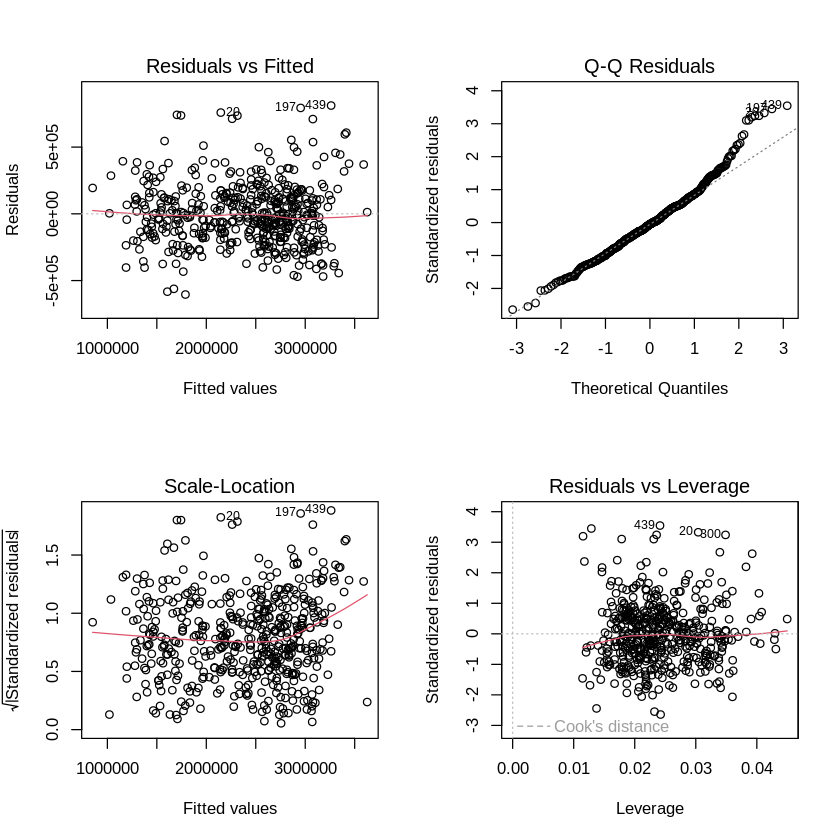

In [577]:
# Asumo que ya tienes el modelo final en 'mod' y los datos en train_data
par(mfrow = c(2, 2))
plot(mod)              # 4 plots clásicos de diagnóstico
par(mfrow = c(1, 1))


In [575]:
library(lmtest); library(sandwich)
dwtest(mod)                               # autocorrelación
bptest(mod)                                # heterocedasticidad
coeftest(mod, vcov = NeweyWest(mod, lag = 2))  # SE robustos (reporta estos)


	Durbin-Watson test

data:  mod
DW = 1.3725, p-value = 3.738e-13
alternative hypothesis: true autocorrelation is greater than 0



	studentized Breusch-Pagan test

data:  mod
BP = 41.525, df = 11, p-value = 1.957e-05



t test of coefficients:

                     Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)        1524126.76   57062.30  26.7099 < 2.2e-16 ***
banner_impressions   77842.22   12157.42   6.4029 3.612e-10 ***
spend_olv           -40300.24   12537.58  -3.2144  0.001395 ** 
social_impressions   68831.30   23916.16   2.8780  0.004179 ** 
search_clicks        88247.54   14288.51   6.1761 1.393e-09 ***
compA_spend        -272622.25   25110.78 -10.8568 < 2.2e-16 ***
compB_spend         -82745.48   14502.79  -5.7055 2.023e-08 ***
trend                 -487.07     181.88  -2.6780  0.007658 ** 
tv_invest_lag1      -32202.40   13960.78  -2.3066  0.021497 *  
regionEast         1769773.37   63162.33  28.0194 < 2.2e-16 ***
regionNorth         881530.95   37231.76  23.6769 < 2.2e-16 ***
regionSouth        1273040.82   37187.15  34.2334 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


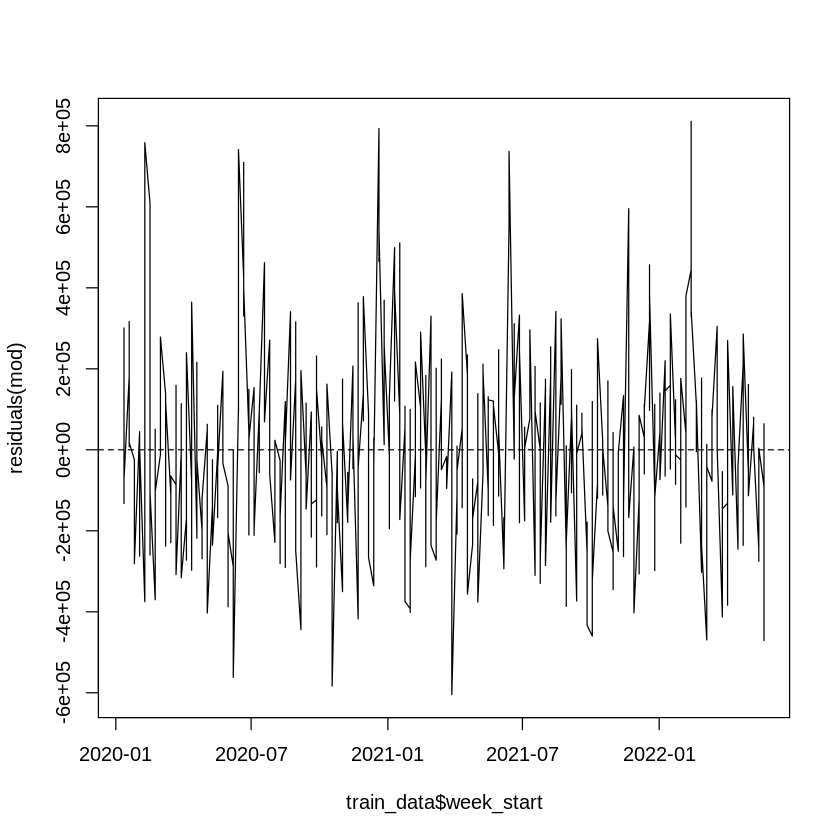

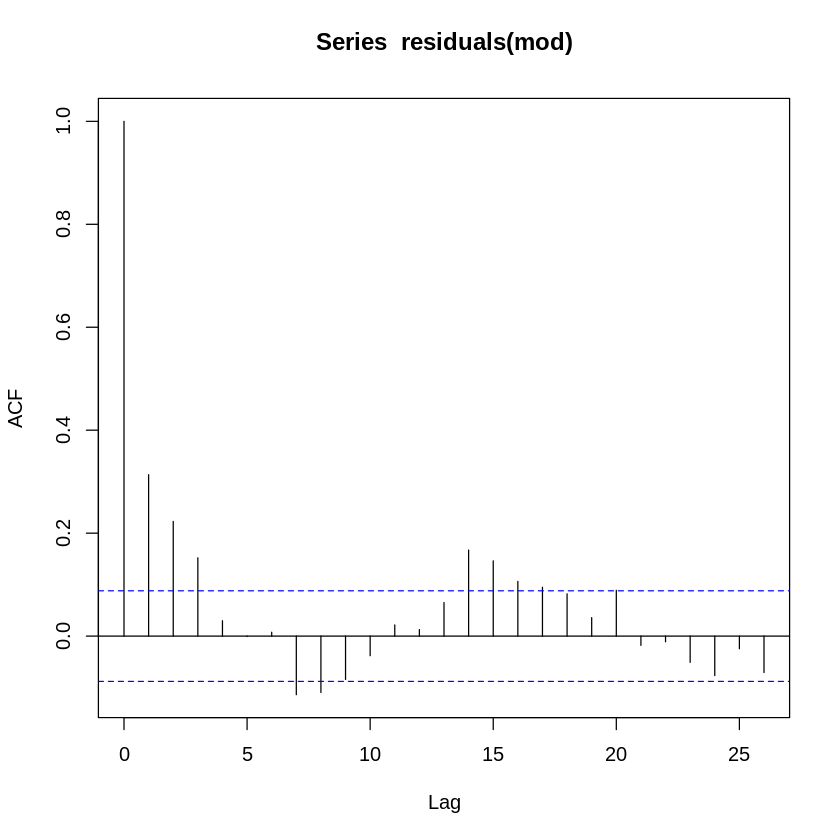

In [579]:
plot(train_data$week_start, residuals(mod), type="l"); abline(h=0,lty=2)
acf(residuals(mod))


In [580]:
library(lmtest); library(sandwich)
bw <- floor(4 * (nobs(mod)/100)^(2/9))   # ancho tipo Andrews
coeftest(mod, vcov = NeweyWest(mod, lag = bw, prewhite = TRUE))


t test of coefficients:

                     Estimate Std. Error  t value  Pr(>|t|)    
(Intercept)        1524126.76   56696.94  26.8820 < 2.2e-16 ***
banner_impressions   77842.22   12434.64   6.2601 8.488e-10 ***
spend_olv           -40300.24   12465.27  -3.2330  0.001309 ** 
social_impressions   68831.30   24773.19   2.7785  0.005674 ** 
search_clicks        88247.54   14257.30   6.1896 1.287e-09 ***
compA_spend        -272622.25   25204.69 -10.8163 < 2.2e-16 ***
compB_spend         -82745.48   15542.25  -5.3239 1.557e-07 ***
trend                 -487.07     184.87  -2.6346  0.008694 ** 
tv_invest_lag1      -32202.40   13817.11  -2.3306  0.020184 *  
regionEast         1769773.37   61008.11  29.0088 < 2.2e-16 ***
regionNorth         881530.95   35313.26  24.9632 < 2.2e-16 ***
regionSouth        1273040.82   36481.92  34.8951 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
